# OR Tools for Robot & Drone VRP

##### **目標**

比較 **VRP**、**Drone VR**、**Robot VRP**、**Drone & Robot VRP**，四種組合在不同參數下的表現

- **表現指標**: 總路徑時間, 總路徑長度, 時間複雜度, 空間複雜度 

##### **參數**
- 不同地圖大小 (5x5, 10x10, 15x15, 20x20, 25x25)
- 不同客戶數量 (210, 180, 150, 130, 110): 從 30 次的重複模擬實驗結果取平均, 趨近於 8 小時的 Nodes 數量
- 1 台車
- 蒙地卡羅模擬次數 10 次以上

##### **實驗假設**

- 每個客戶點的貨物數量、尺寸皆相同
- 每個客戶點的服務時間皆為 2 分鐘
- 實驗載具共有 Truck、Drone 與 Robot 三種載具
- 一台 Truck 配置 1 台 Drone 與 Robot，且 Drone 與 Robot 可以同時在路上跑
- Drone 與 Robot 可以由 Truck 於任意客戶點中派出與回收，派出與回收各需要花費 1 分鐘
- Truck 可以多次派出 Drone 與 Robot
- 若 Truck 抵達回收點時 Drone 與 Robot 尚未返回，需記錄等待時間
- 司機可以有等待時間，但不能提前 10 分鍾以上到達
- Truck 載具的速度為 60 km/hr，使用曼哈頓距離計算，載貨量為 **服務點 ÷ 車輛數** (考量平均工作量)
- Drone 載具的速度為 80 km/hr，使用歐式距離計算，每次只能載 1 個貨物, 電池續航力為 60 分鐘
- Robot 載具的速度為 60 km/hr，使用曼哈頓距離計算，每次只能載 4 個貨物, 電池續航力為 120 分鐘

##### **Drone 挑選方法說明**

- 以 OR-Tools 初始解分組, 找出每組中最適合派給 Drone 的點
- 篩選出最近點距離最遠的 n 個點作為 Drone 效益最高的點, n 設定為 25 百分位數
- 設定其原路徑為 Drone 的可能發收站, 並排除掉 Node 為其他 Drone 發收站的點

##### **Robot 挑選方法**

- 從 Initial Solution 中抓出最短的路徑組合 (10 個造訪點一組, 如數量 <= 10 則不考慮出車)
- 路徑組合的造訪時間不可超過 Robot 電池續航力
- 根據距離排序, 排除掉 Node 重複的組合
- 篩選出前 25 百分位數近的組合

In [81]:
import random as rd
import numpy as np
import pandas as pd
import math
import copy as copy
# OR-Tools
from ortools.constraint_solver import routing_enums_pb2 
from ortools.constraint_solver import pywrapcp 
# Record time & space complexity
import time 
import tracemalloc
# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Parameters: 實驗參數設定

In [82]:
# [實驗控制變數] 
# 地圖大小(km) | 服務點數量 | 車輛數量
# MAX_X, MAX_Y = 20, 20
# NUM_NODES = 30
# NUM_VEHICLES = 1

# 站點服務時間
SERVICE_TIME = 2

# [Truck]
# 時速 60km | 每台車有最大移動距離(固定) | 貨物重量相同 | 本實驗不考慮車輛成本, 故每台車可載貨物數量 = (站點/車輛數)
VEHICLE_SPEED = 60
# VEHICLE_CAPACITIES = int(NUM_NODES / NUM_VEHICLES)

# [Drone]
# 時速 80km | 續航力 60 min | 採用歐幾里德距離 | 負責離群值 | 派出與收回載具各需要 1 分鐘 (總共2)
DRONE_CAPACITIES = 1
DRONE_SPEED = 80
DRONE_BATTERY_LIFE = 60
DRONE_DISPATCH_TIME = 1
FILTER_RATE = 

# [Robot]
# 時速 30km | 續航力 120 min | 負責高密度點 | 派出與收回載具各需要 1 分鐘 (總共2)
ROBOT_CAPACITIES = 10
ROBOT_SPEED = 60
ROBOT_BATTERY_LIFE = 120
ROBOT_DISPATCH_TIME = 2

## Model: 資料層設定

In [83]:
# 模擬實驗需求, 函式需帶入控制變數
# **controls = dict(map_size=(20, 20), num_nodes=20, num_vehicles=1)
def create_data_model(**controls):
    
    NUM_NODES = controls["num_nodes"]
    MAX_X, MAX_Y = controls["map_size"][0], controls["map_size"][1]
    NUM_VEHICLES = controls["num_vehicles"]
    VEHICLE_CAPACITIES = controls["num_nodes"] // controls["num_vehicles"] # 如果非整數需分配給其他車輛
    
    data = {}
    data["num_locations"] = [(round(np.random.uniform(0, MAX_X), 3), round(np.random.uniform(0, MAX_Y), 3)) for i in range(NUM_NODES)]
    data["num_locations"][0] = (round((MAX_X / 2), 3), round((MAX_Y / 2), 3)) 
    data["distance_matrix"] = compute_manhattan_distance_matrix(data["num_locations"]) # 距離矩陣必須為整數, 否則無法在 OR-Tools 中求解
    data["e_distance_matrix"] = compute_euclidean_distance_matrix(data["num_locations"]) # 歐幾里德距離, 取小數第二位(drone 使用)
    data["time_matrix"] = compute_time_matrix(data["distance_matrix"]) # 最小單位分鐘
    data["num_nodes"] = NUM_NODES
    data["num_vehicles"] = NUM_VEHICLES
    data["depot"] = 0 # Depot 的索引值
    data["time_windows"] = []
    data["initial_routes"] = [] # 如果有初始解可以套用
    data["demands"] = [1 for i in range(NUM_NODES)]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    if NUM_NODES % VEHICLE_CAPACITIES > 0:
        for i in range(NUM_NODES % VEHICLE_CAPACITIES):
            data["vehicle_capacities"][i] += 1
    # 三個載具負責的 node 索引值
    data["vehicle"] = []
    data["drone"] = []
    data["robot"] = []    
    return data

# 曼哈頓距離矩陣, truck & robot 用 (單位使用 m, 小於 1km 的距離會無法解題)
def compute_manhattan_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                manhattan_distance = np.sum(np.abs(np.array(node_i) - np.array(node_j)))
                distances.append(int(manhattan_distance * 1000))
        distance_matrix.append(distances)
    return distance_matrix

# 歐式距離矩陣, drone 使用 (單位 m)
def compute_euclidean_distance_matrix(nodes):
    distance_matrix = []
    for node_i in nodes:
        distances = []
        for node_j in nodes:
            if node_i == node_j:
                distances.append(0)
            else:
                euclidean_distance = np.sqrt((node_i[0] - node_j[0])**2 + (node_i[1] - node_j[1])**2)
                distances.append(int(euclidean_distance * 1000))
        distance_matrix.append(distances)
    return distance_matrix

# 距離矩陣轉換為時間矩陣 (兩點花費分鐘 = 公里 / 時速 * 60)
def compute_time_matrix(distance_matrix):
    time_matrix = []
    for i in distance_matrix:
        time_matrix.append(list(map(lambda x: round(x / 1000 / VEHICLE_SPEED * 60, 3), i)))
    return time_matrix

## Controller: 控制層設定

In [84]:
# 取得目標值(時間和/分鐘): 提供路徑, 速度, 參考距離矩陣, 會考量每個點的服務時間
def get_objective_value(data, route, speed=VEHICLE_SPEED, matrix='distance_matrix'):
    objective_value = 0
    for i in range(len(route) - 1):
        objective_value += (data[matrix][route[i]][route[i + 1]] / 1000) + SERVICE_TIME # 該點服務時間
    objective_value = objective_value / speed * 60
    return round(objective_value, 3)

# 計算路徑總距離
def get_total_distance(data, route):
    total_dist = 0
    for i in range(len(route) - 1):
        total_dist += data['distance_matrix'][route[i]][route[i + 1]]
    return round(total_dist, 3)

# 計算每台車的總等待時間
def get_waiting_time(data, routes, sidekick_routes, name):
    assert name == 'drone' or name == 'robot'
    # print(f'Vehicle: \n{name}')
    total = 0
    waiting_time_list = [[] for i in range(len(sidekick_routes))]
    for i, group in enumerate(sidekick_routes):
        for j, r_s in enumerate(group): # 每筆路徑
            if name == 'drone':
                dur_s = get_objective_value(data, r_s, DRONE_SPEED, 'e_distance_matrix')
            elif name == 'robot':
                dur_s = get_objective_value(data, r_s, ROBOT_SPEED, 'distance_matrix')
            start, end = r_s[0], r_s[-1]
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)      
            # print(f'Sidekick: {r_s}, Vehicle: {r_v}')
            # print(f'-T(s): {dur_s}, T(v): {dur_v}')
            if dur_s > dur_v: # 如果 sidekick 時間比較長, 記錄為等待時間
                # print('-Wait for:', (dur_s - dur_v))
                waiting_time_list[i].append(round(dur_s - dur_v, 3))  
                total += (dur_s - dur_v)
            else:
                waiting_time_list[i].append(0)
        if waiting_time_list[i] == []:
            waiting_time_list[i] = [0]
    return waiting_time_list

# 計算每台車輛的總服務時間: 目標值 + 等待時間 + 收放時間; VRP 問題不會有等待時間
def get_travelling_time(data, routes, drone_waiting=[], robot_waiting=[]):

    total_dist, total_time, total_waiting  = [], [], []

    for index, route in enumerate(routes):
        dist = get_total_distance(data, route)
        dur_v = get_objective_value(data, route)
        waiting = 0

        if len(drone_waiting) > 0:
            dur_v += np.sum(drone_waiting[index])
            waiting += np.sum(drone_waiting[index])

        if len(robot_waiting) > 0:
            dur_v += np.sum(robot_waiting[index])
            waiting += np.sum(robot_waiting[index])

        total_dist.append(round(dist, 3))
        total_time.append(round(dur_v, 3))
        total_waiting.append(round(waiting, 3))
        print(f'Vehicle {index}: {dist} m, {round(dur_v, 3)} min, including {round(waiting, 3)} mins waiting time.')

    print(f'Total distance of all routes: : {np.sum(total_dist)} m')
    print(f'Maximum travel time: {round(max(total_time), 3)} min')
    return total_dist, total_time, total_waiting

# 計算派遣載具時間(1+1 = 2)
def get_dispatch_time(routes):
    dispatch_time = []
    for i, group in enumerate(routes):
        dispatch_time.append(len(group) * 2)
    return dispatch_time

# 重置 Node 的貨物需求
def reset_demands(data, **controls):

    NUM_VEHICLES = controls["num_vehicle"]
    VEHICLE_CAPACITIES = int(controls["num_nodes"] / controls["num_vehicle"])
    data["demands"] = [1 for i in range(data["num_nodes"])]
    data["demands"][0] = 0
    data["vehicle_capacities"] = [VEHICLE_CAPACITIES for i in range(NUM_VEHICLES)]
    return data

def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0

    for vehicle_id in range(data["num_vehicles"]):
        index = routing.Start(vehicle_id)
        plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_load = 0
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            plan_output += f" {node_index} ({route_distance}) -> "
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        plan_output += f" {manager.IndexToNode(index)} ({route_distance})\n"
        plan_output += f"Distance of the route: {route_distance} km\n"
        plan_output += f"Load of the route: {route_load}\n"
        print(plan_output)
        total_distance += route_distance
        total_load += route_load
    
    print(f"Total distance of all routes: {total_distance} km")
    print(f"Total load of all routes: {total_load}")

# Save routes to a list or array
def get_routes(solution, routing, manager):
    """Get vehicle routes from a solution and store them in an array."""
    # Get vehicle routes and store them in a two dimensional array whose
    # i,j entry is the jth location visited by vehicle i along its route.
    routes = []
    for route_nbr in range(routing.vehicles()):
        index = routing.Start(route_nbr)
        route = [manager.IndexToNode(index)]
        while not routing.IsEnd(index):
            index = solution.Value(routing.NextVar(index))
            route.append(manager.IndexToNode(index))
        routes.append(route)
    return routes

# OR Tools = manager + routing + search_parameter = solution
def solve_routing_problem(data):
    ''' 路徑管理員 RoutingIndexManager '''
    # data 中有新資料需於此處引用
    manager = pywrapcp.RoutingIndexManager(
        len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
    )
    ''' 路徑資料 RoutingModel '''
    routing = pywrapcp.RoutingModel(manager)
    # 計算 node 貨物需求的工具
    def demand_callback(from_index):
        from_node = manager.IndexToNode(from_index)
        return data["demands"][from_node]

    demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(
        demand_callback_index,
        0,  # null capacity slack
        data['vehicle_capacities'],  # vehicle maximum capacities
        False,  # start cumul to zero
        "Capacity",
    )

    # 計算 node 間距離單位的工具, 調整距離計算方法可從函式 return 中修改
    def distance_callback(from_index, to_index):
        from_node = manager.IndexToNode(from_index) # 取得開始到結束點的索引值
        to_node = manager.IndexToNode(to_index)
        return data["distance_matrix"][from_node][to_node] # 若題目為 VRPTW 需回傳 data["time_matrix"]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback) # 設定所有車輛距離(arc)間的評估單位
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # routing.SetArcCostEvaluatorOfVehicle() # 打開後可定義其他車輛距離的評估單位

    # 設定車輛行駛中累積的變量, VRPTW 時需將 demension_name 調整為 "Time"
    routing.AddDimension(
        transit_callback_index,
        0,  # 車輛最大等待時間, VRPTW 用
        999999999,  # 車輛最大行駛距離
        False,  # 每輛車路線開始時，累計變數是否設為零 (VRPTW 時需調整為 False, 讓時間可累積)
        "Distance",
    )
    distance_dimension = routing.GetDimensionOrDie("Distance")
    # distance_dimension.SetGlobalSpanCostCoefficient(0) # 成本係數設定成 100 會無法跑少數量的車輛路線

    # 設計懲罰項: AddDisjuntion() 只能呼叫一次, 要將 node 排除在路徑中需要調整 Capacity
    penalty = 100000
    for node in range(1, len(data["distance_matrix"])):
        routing.AddDisjunction([manager.NodeToIndex(node)], penalty)

    # 平衡車輛 loading, 避免部分車輛跑有路線
    for vehicle_id in range(data['num_vehicles']):
        routing.SetVehicleUsedWhenEmpty(True, vehicle_id)

    routing.AddConstantDimension(
        1, # +1 for each visit (note start node is counted so unused vehicle is still 1)
        data["num_nodes"] // data["num_vehicles"] + 2, # max visit allowed,  hard limit
        True,  # start cumul to zero
        "Counter")
        
    counter_dimension = routing.GetDimensionOrDie("Counter")
    for vehicle_id in range(manager.GetNumberOfVehicles()):
        index = routing.End(vehicle_id)
        counter_dimension.SetCumulVarSoftLowerBound(index, 2, 100000) # penalty of 100000 for each empty vehicle since counter will be 1 aka (2 - 1) * 100_000  

    ''' 啟發式演算法參數 search_parameters '''
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC # 最快求解法, 預設為 PATH_CHEAPEST_ARC '''
    )
    search_parameters.local_search_metaheuristic = (
        routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH     # 開啟後會改用 guided local search 求解 local minimum (GREEDY_DESCENT, TABU_SEARCH, Simulated Annealing...)
    )
    # search_parameters.time_limit.seconds = 5 # 搜尋時間限制
    # search_parameters.log_search = True # 開啟後會顯示每次搜尋迭代(log)
    search_parameters.solution_limit = 100 # 解決方案限制
    
    routing.CloseModelWithParameters(search_parameters) # 提供初始解時關閉搜尋參數
    # initial_solution = routing.ReadAssignmentFromRoutes(data["initial_routes"], True) # 求解前如果想提供初始路徑解可打開

    solution = routing.SolveWithParameters(search_parameters) # 將準備好的 search_parameter 提供給 OR Tools 求解
    if solution: # 有找到解的話顯示答案
        routes = get_routes(solution, routing, manager)
        print(f'Routes: {routes}, Length: {len(routes[0])}')
        # print_solution(data, manager, routing, solution)
        # 檢查路徑是否有跑完所有的點
        serviced_node = sum([len(i) for i in routes]) - 1
        if serviced_node != data["num_nodes"]:
            print(f'Warming: 僅訪問 {serviced_node} 個客戶點!')
        return routes
    else:
        print('No solution!')
        return []

In [117]:
def select_drone_nodes(data, routes, excludes=[]):

    # 找出最近距離 Node 排序
    nearest_dists = []
    for i in data['e_distance_matrix']:
        sorted_i = sorted(i)
        nearest_dists.append(sorted_i[1])
    sorted_nearest_indexes = np.argsort(nearest_dists).tolist()[::-1]
    sorted_nearest_indexes = sorted_nearest_indexes[:int(data["num_nodes"])] 
    sorted_nearest_indexes.remove(0)

    # 將 Node 分配到初始解車輛路徑中
    drone_nodes = [[] for i in range(len(routes))]
    for i, route in enumerate(routes):
        for j in sorted_nearest_indexes:
            drone_nodes[i].append(j) if j in route else None
        drone_nodes[i] = drone_nodes[i][:int(len(route)/4)] # 根據中位數篩選出前 25% 最遠的點

    # 如果有先解出 Robot 點, 需將 Robot 的收發站排除掉
    if len(excludes) > 0:
        for i, group in enumerate(excludes):
            for j, nodes in enumerate(group):
                for n in nodes:
                    drone_nodes[i].remove(n) if n in drone_nodes[i] else None
         
    drone_routes = [[] for i in range(len(routes))]
    for i, group in enumerate(drone_nodes):
        exclusion = []
        # 取得 Drone 的合適路徑
        for n in group:
            # 原路徑鄰的點不能為其他 Drone 點
            if n not in exclusion:
                start, end = routes[i].index(n)-1, routes[i].index(n)+1
                exclusion.append(routes[i][start])
                exclusion.append(routes[i][end])
                route = [routes[i][start], n, routes[i][end]]
                drone_routes[i].append(route)

    # 排除不佳的路線: 會造成等待的 or 超過電池容量
    for i, group in enumerate(drone_routes):
        for r in group:
            dur_d = get_objective_value(data, r, DRONE_SPEED, 'e_distance_matrix')
            if dur_d > DRONE_BATTERY_LIFE: # 超過電池續航力
                drone_routes[i].remove(r)
                continue
            start, end = r[0], r[-1]
            r_v = routes[i][routes[i].index(start):routes[i].index(end)+1]
            dur_v = get_objective_value(data, r_v, VEHICLE_SPEED)      
            if dur_d + 2 >= dur_v: # Drone 較晚到達會產生等待 & 多花 2min 派遣 Drone 不如自己去跑
                # print('Remove:', r)
                drone_routes[i].remove(r)

    return drone_routes

In [221]:
def select_robot_nodes(data, routes):

    robot_routes = [[] for i in range(len(routes))]
    
    for index, route in enumerate(routes):
        # print('Choosing the nodes for Robot:', route)
        if len(route) <= ROBOT_CAPACITIES + 2:
            continue
        route_filter = []
        for j in range(len(route)):
            if j <= (len(route) - ROBOT_CAPACITIES - 2):
                robot_route = route[j:j + ROBOT_CAPACITIES + 2]            
                r_dur = get_objective_value(data, robot_route, ROBOT_SPEED)
                if r_dur <= ROBOT_BATTERY_LIFE: # 排除超過電池續航力(ROBOT_BATTERY_LIFE)的路徑組合
                    # print(f'Route {j}: {robot_route}, Duratoin: {r_dur}')
                    route_filter.append({ 'route': robot_route, 'duration': r_dur }) 
        # 根據最短時間(duration)排序, 並排除掉重複 Node 的路徑組合
        route_filter.sort(key=lambda x: x['duration'])
        if len(route_filter) >= ROBOT_CAPACITIES:
            route_filter = route_filter[:int(len(route_filter)/4)] # 保留 25% 路徑組合
        best_routes = [route_filter[0]['route']]
        # print(best_routes)
        for r_dict in route_filter:
            overlap = 0
            for best_r in best_routes:
                if len(set(best_r) & set(r_dict['route'])) > 0:
                    overlap += 1
                    break
            if overlap == 0:
                best_routes.append(r_dict['route'])
        robot_routes[index] = best_routes
    # 每台車只會派出 Robot 一次
    # robot_routes = [[robot_routes[i][0]] for i in range(len(routes))]
    print('Robot Routes:', robot_routes)
    return robot_routes

def adjust_robot_route(data, route, robot_group):
    print(f"Route: {route}, Robot Group: {robot_group}")
    a_route = route.copy()
    a_robot_group = robot_group.copy()

    for index, route_r in enumerate(robot_group):
        route_t = [route_r[0], route_r[-1]]
        dur_r = get_objective_value(data, route_r, ROBOT_SPEED)
        dur_t = get_objective_value(data, route_t)
        if dur_r > dur_t:
            # 1. forward stepwise search
            route_f = route[route.index(route_t[-1])+1:] if route_t[-1] != 0 else [0] # 取得 Truck 接下來的路線
            # exclude other dispatch nodes
            for i in a_robot_group:
                if i[0] in route_f:
                    route_f = route_f[:route_f.index(i[0]) + 1] # 排除其他 Truck 的路線
            # (Old) Truck 先去跑其他路徑, 時間差不多後再返回. 較沒有效率
            # select the best route
            # diff_abs = [abs(get_objective_value(data, [route_t[0]] + route_f[:i] + [route_t[-1]]) - dur_r) for i in range(len(route_f))]
            # new_route = [route_t[0]] + route_f[:diff_abs.index(min(diff_abs))] + [route_t[-1]]
            # (New) Robot 結束後到最近的點與 Truck 會合
            trigger_f = 0 # 是否有更佳解的觸發器
            diff_abs_f = []
            diff_abs_f.append(abs(dur_r-dur_t)) # 如果沒有更好解時, 有可能保留原始解
            for i, ele in enumerate(route_f):
                route_fr = route_r[:-1] + [ele]
                route_ft = route_t + route_f[:i+1]
                dur_fr = get_objective_value(data, route_fr, ROBOT_SPEED)
                if dur_fr > ROBOT_BATTERY_LIFE: # 超出電池續航力
                    continue
                dur_ft = get_objective_value(data, route_ft)
                diff_abs_f.append(abs(dur_fr-dur_ft))
                # 找到不用等待的解, 更新路徑
                if dur_fr < dur_ft:
                    new_route = route_ft
                    a_robot_group[index] = route_fr
                    trigger_f += 1
                    break
            # 如果 forward 後所有的解都要等待, 找出相對好的解
            if trigger_f == 0:
                best_i = diff_abs_f.index(min(diff_abs_f))
                if best_i != 0: # 新路線比較好
                    a_robot_group[index] = route_r[:-1] + [route_f[best_i - 1]]
                    new_route = route_t + route_f[:best_i]
                    dur_fr = get_objective_value(data, route_r[:-1] + [route_f[best_i - 1]], ROBOT_SPEED)   
                else: # 原路線比較好
                    new_route = route_t
                    dur_fr = dur_r
            # 2. backward stepwise search (if truck still needs waiting)
            dur_ft = get_objective_value(data, new_route)
            if dur_fr > dur_ft:
                trigger_b = 0
                diff_abs_b = []
                diff_abs_b.append(abs(dur_fr - dur_ft))
                # print("-Current waiting time:", dur_r - get_objective_value(data, new_route))
                route_b = route[:route.index(route_t[-1])]
                # exclude other recall nodes
                for i in a_robot_group:
                    if i[-1] in route_b:
                        route_b = route_b[route_b.index(i[-1]):]                
                # select the best route
                for i in range(2 ,len(route_b)):
                    start = route_b[-i]
                    route_br = [start] + route_r[1:]
                    route_bt = a_route[a_route.index(start):a_route.index(route_r[0])] + new_route
                    dur_br = get_objective_value(data, route_br, ROBOT_SPEED)
                    dur_bt = get_objective_value(data, route_bt)
                    # print("--Waiting time:", dur_br - dur_bt)
                    if dur_bt > dur_br:
                        new_route = route_bt
                        a_robot_group[index] = route_br
                        trigger_b += 1
                        break
                # 如果 backward 後所有的解都要等待, 找出相對好的解
                if trigger_b == 0:
                    best_i = diff_abs_b.index(min(diff_abs_b))
                    if best_i != 0: # 新路線比較好
                        print('Find the better robot route by backward search')
                        a_robot_group[index] = route_b[-best_i] + a_robot_group[index][1:]       
            # print('Origin:', a_route[a_route.index(new_route[0]):a_route.index(new_route[0]) + len(new_route)])
            # print('New:', new_route)
            a_route[a_route.index(new_route[0]):a_route.index(new_route[0]) + len(new_route)] = new_route

    # print(f"Adjusted Truck Route: {a_route}")
    # print(f"Adjusted Robot Route: {a_robot_group}")

    return a_route, a_robot_group

## View: 畫面顯示

In [175]:
def plot_map(routes, drone_routes=[], robot_routes=[], **controls):
    plt.figure(figsize=(7, 7))
    plt.grid(color='gray', linestyle='-', linewidth=1, alpha=0.2)
    plt.xlim(-1, controls["map_size"][0]+1)
    plt.ylim(-1, controls["map_size"][1]+1) 
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    color_palette = [(0, 0.5, 1), (0.8, 0, 0), (0.0, 0.6, 0.2), (1, 0.7, 0.4)]
    passed_nodes = []

    def draw_line(route, color='gray'):
        arrow_kwargs = dict(length_includes_head=True, head_width=0.15, head_length=0.3, color=color, alpha=0.8)
        for index, node in enumerate(route):
            if index < len(route) - 1:
                start_loc = data['num_locations'][route[index]]
                end_loc = data['num_locations'][route[index + 1]] 
                plt.arrow(x=start_loc[0], y=start_loc[1], dx=(end_loc[0] - start_loc[0]), dy=(end_loc[1] - start_loc[1]), **arrow_kwargs)
    
    def draw_node(node, color='gray', marker='o', label='node'):
        text_kwargs = dict(s=str(node), fontsize=7.5, color="white", horizontalalignment='center', verticalalignment='center')
        node_kwargs = dict(s=150, color=color, alpha=0.8, edgecolors='black', marker=marker, label=label)
        loc = data['num_locations'][node]
        plt.scatter(x=loc[0], y=loc[1], **node_kwargs)
        # plt.text(x=loc[0], y=loc[1], **text_kwargs)
        passed_nodes.append(node)

    if len(routes) > 0:
        # Draw VRP solution
        for i_route, route in enumerate(routes):
            RGB_color = color_palette[i_route]
            draw_line(route, RGB_color)
            # Draw vehicle nodes
            for i in route:
                if i != 0:
                    draw_node(node=i, color=RGB_color)
            # Draw drone nodes
            if len(drone_routes) > 0:
                for route in drone_routes[i_route]:
                    drone_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route, color=drone_color)
                        if index == 1:
                            draw_node(node, color=drone_color, marker='D', label='drone')         
            # Draw robot nodes
            if len(robot_routes) > 0:
                for route in robot_routes[i_route]:
                    robot_color = 'gray'
                    for index, node in enumerate(route):
                        if index != (len(route) - 1):
                            draw_line(route)
                        if 0 < index < (len(route) - 1):
                            draw_node(node, color=robot_color, marker='H', label='robot')
        # Draw un-passed nodes    
        unpassed_nodes = [i for i in range(data["num_nodes"]) if i not in passed_nodes]
        if len(unpassed_nodes) > 0:
            for index in unpassed_nodes:
                draw_node(index)
        # Draw depot
        draw_node(node=0, color='black', marker='s') 
    # No route, plot map & nodes
    else:
        if len(data['num_locations']) > 0:
            for index, node in enumerate(data['num_locations']):
                draw_node(index) # depot
            draw_node(node=0, color='black', marker='s', label='depot')
        else:
            print("No data.")

## VRP 解題方法說明

,num_locations,distance_matrix,e_distance_matrix,time_matrix,num_nodes,num_vehicles,depot,time_windows,initial_routes,demands,vehicle_capacities,vehicle,drone,robot
0,"[(12.5, 12.5), (15.069, 13.622), (10.591, 16.1...","[[0, 3691, 5555, 11354, 14505, 8014, 12341, 21...","[[0, 2803, 4116, 9917, 11952, 7328, 10775, 148...","[[0.0, 3.691, 5.555, 11.354, 14.505, 8.014, 12...",110,1,0,[],[],"[0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",[110],[],[],[]


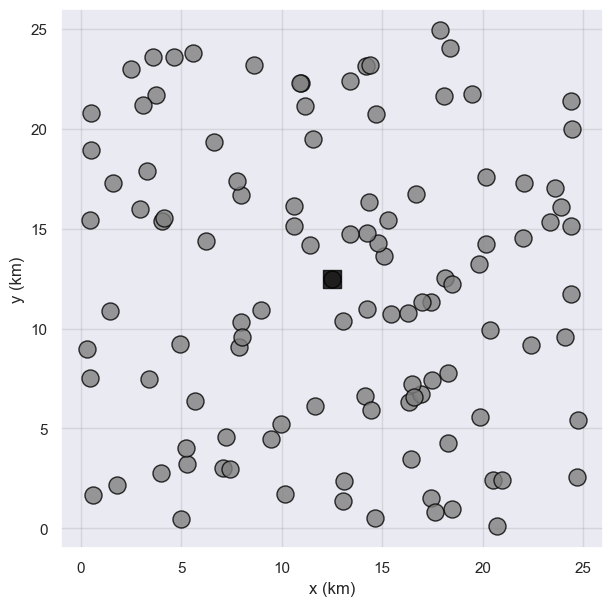

In [223]:
# Set data & control parameter
controls = dict(map_size=(25, 25), num_nodes=110, num_vehicles=1)
np.random.seed(0)
data = create_data_model(**controls)

plot_map(routes=[], **controls)

pd.json_normalize(data)

### VRP

Routes: [[0, 82, 76, 51, 88, 48, 37, 103, 36, 93, 17, 61, 92, 4, 100, 64, 3, 97, 18, 49, 59, 16, 39, 9, 75, 53, 91, 99, 31, 11, 90, 23, 69, 62, 43, 63, 15, 109, 89, 79, 77, 5, 32, 68, 74, 41, 50, 70, 22, 25, 29, 34, 58, 10, 30, 2, 38, 80, 66, 21, 44, 42, 45, 87, 35, 20, 95, 73, 98, 47, 6, 106, 12, 83, 94, 102, 71, 108, 60, 81, 8, 57, 55, 104, 107, 33, 1, 65, 52, 86, 7, 67, 101, 19, 24, 26, 14, 72, 46, 27, 40, 13, 85, 54, 84, 28, 78, 96, 56, 105, 0]], Length: 111
Vehicle 0: 240263 m, 460.263 min, including 0 mins waiting time.
Total distance of all routes: : 240263 m
Maximum travel time: 460.263 min


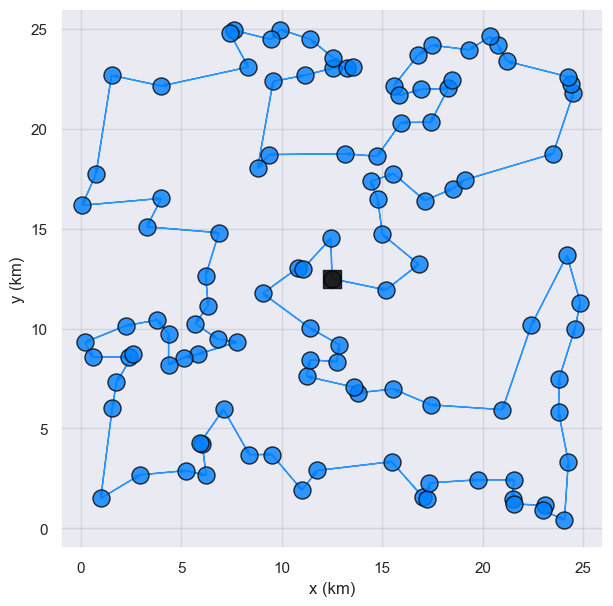

In [178]:
VRP_routes = solve_routing_problem(data)
total_dist, total_time, waiting_time = get_travelling_time(data, VRP_routes)
plot_map(routes=VRP_routes, **controls)

### VRP + Drone

Routes: [[0, 14, 25, 65, 1, 53, 93, 67, 68, 18, 22, 72, 59, 19, 61, 92, 58, 78, 5, 97, 60, 80, 103, 69, 57, 94, 56, 64, 50, 106, 28, 91, 42, 29, 95, 101, 47, 39, 38, 23, 27, 30, 7, 102, 86, 79, 43, 85, 48, 89, 37, 21, 31, 84, 87, 33, 49, 34, 26, 105, 70, 4, 35, 36, 10, 82, 9, 51, 74, 81, 109, 44, 6, 104, 11, 55, 3, 71, 88, 54, 96, 13, 73, 75, 77, 8, 107, 41, 46, 12, 90, 76, 17, 99, 83, 63, 66, 98, 32, 24, 108, 40, 20, 52, 15, 100, 45, 2, 62, 16, 0]], Length: 111
Waiting time: [[0, 0, 0, 0, 1.841, 4.011, 1.396, 0, 0, 0.226, 0.839, 0.576, 0, 0, 0, 0, 1.131]]
Vehicle 0: 238613 m, 434.633 min, including 10.02 mins waiting time.
Total distance of all routes: : 238613 m
Maximum travel time: 434.633 min


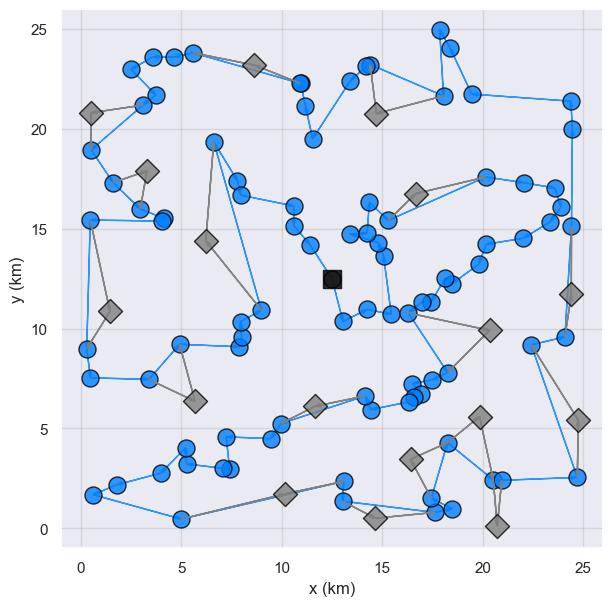

In [179]:
# 解 VRP -> 分開挑選 Drone 點 -> 連接路線
np.random.seed(0)
data = create_data_model(**controls)
VRPD_routes = solve_routing_problem(data)
drone_routes = select_drone_nodes(data, VRPD_routes)
# 調整車輛路線
for index, group in enumerate(drone_routes):
    for r in group:
        VRPD_routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, VRPD_routes, drone_routes, 'drone')
print("Waiting time:", drone_waiting)
total_dist, total_time, waiting_time = get_travelling_time(data, VRPD_routes, drone_waiting)

plot_map(routes=VRPD_routes, drone_routes=drone_routes, robot_routes=[], **controls)

### VRP + Robot

Routes: [[0, 38, 62, 10, 51, 29, 2, 15, 76, 59, 79, 65, 97, 17, 107, 74, 45, 56, 5, 26, 60, 68, 106, 7, 36, 12, 83, 57, 64, 96, 77, 53, 54, 6, 67, 4, 20, 88, 25, 61, 14, 78, 72, 39, 23, 102, 43, 47, 33, 93, 69, 86, 16, 27, 80, 9, 28, 11, 44, 32, 52, 101, 103, 13, 90, 19, 98, 109, 92, 73, 91, 75, 70, 21, 104, 85, 66, 108, 18, 34, 84, 8, 48, 87, 22, 81, 94, 63, 35, 37, 42, 1, 46, 24, 40, 89, 105, 55, 50, 95, 100, 49, 41, 99, 31, 58, 71, 3, 82, 30, 0]], Length: 111
Robot Routes: [[[87, 22, 81, 94, 63, 35, 37, 42, 1, 46, 24, 40], [76, 59, 79, 65, 97, 17, 107, 74, 45, 56, 5, 26], [101, 103, 13, 90, 19, 98, 109, 92, 73, 91, 75, 70], [72, 39, 23, 102, 43, 47, 33, 93, 69, 86, 16, 27]]]
Route: [0, 38, 62, 10, 51, 29, 2, 15, 76, 26, 60, 68, 106, 7, 36, 12, 83, 57, 64, 96, 77, 53, 54, 6, 67, 4, 20, 88, 25, 61, 14, 78, 72, 27, 80, 9, 28, 11, 44, 32, 52, 101, 70, 21, 104, 85, 66, 108, 18, 34, 84, 8, 48, 87, 40, 89, 105, 55, 50, 95, 100, 49, 41, 99, 31, 58, 71, 3, 82, 30, 0], Robot Group: [[87, 22, 

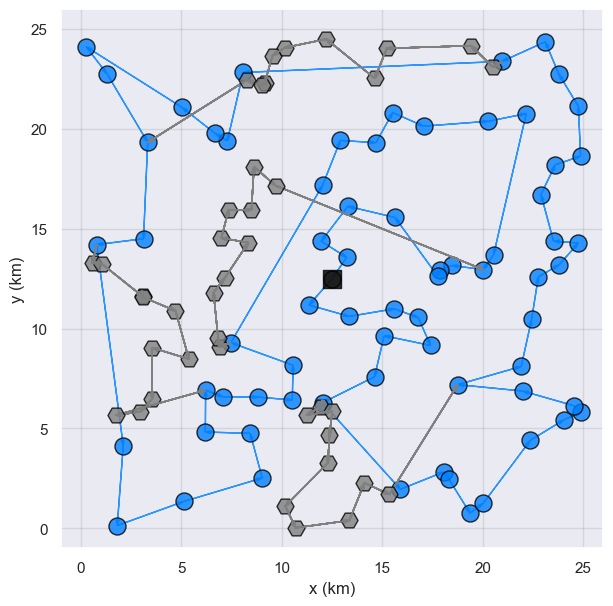

In [220]:
# np.random.seed(0)
data = create_data_model(**controls)
VRPR_routes = solve_routing_problem(data)
robot_routes = select_robot_nodes(data, VRPR_routes)
# 調整車輛路線
for veh_i, group in enumerate(robot_routes):
    for index, route in enumerate(group):
        exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        VRPR_routes[veh_i] = [i for i in VRPR_routes[veh_i] if i not in exclude_nodes]   
    VRPR_routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, VRPR_routes[veh_i], group)

robot_waiting = get_waiting_time(data, VRPR_routes, robot_routes, 'robot')
print("Waiting time:", robot_waiting)
total_dist, total_time, waiting_time = get_travelling_time(data, VRPR_routes, [], robot_waiting)

plot_map(routes=VRPR_routes, robot_routes=robot_routes, **controls)

# 舊版方法 (VRPTW)
# vrptw_routes = solve_vrptw(data, excludes)
# print('\nRoute for VRPTW:', vrptw_routes)
# if vrptw_routes:
#     robot_waiting = get_waiting_time(data, vrptw_routes, robot_routes, 'robot')
# plot_map(routes=vrptw_routes, drone_routes=[], robot_routes=robot_routes, **controls)

### VRP + Drone + Robot

Routes: [[0, 14, 25, 65, 1, 53, 93, 67, 68, 18, 22, 72, 59, 19, 61, 92, 58, 78, 5, 97, 60, 80, 103, 69, 57, 94, 56, 64, 50, 106, 28, 91, 42, 29, 95, 101, 47, 39, 38, 23, 27, 30, 7, 102, 86, 79, 43, 85, 48, 89, 37, 21, 31, 84, 87, 33, 49, 34, 26, 105, 70, 4, 35, 36, 10, 82, 9, 51, 74, 81, 109, 44, 6, 104, 11, 55, 3, 71, 88, 54, 96, 13, 73, 75, 77, 8, 107, 41, 46, 12, 90, 76, 17, 99, 83, 63, 66, 98, 32, 24, 108, 40, 20, 52, 15, 100, 45, 2, 62, 16, 0]], Length: 111
Robot Routes: [[[64, 50, 106, 28, 91, 42, 29, 95, 101, 47, 39, 38], [59, 19, 61, 92, 58, 78, 5, 97, 60, 80, 103, 69], [96, 13, 73, 75, 77, 8, 107, 41, 46, 12, 90, 76]]]
Route: [0, 14, 25, 65, 1, 53, 93, 67, 68, 18, 22, 72, 59, 69, 57, 94, 56, 64, 38, 23, 27, 30, 7, 102, 86, 79, 43, 85, 48, 89, 37, 21, 31, 84, 87, 33, 49, 34, 26, 105, 70, 4, 35, 36, 10, 82, 9, 51, 74, 81, 109, 44, 6, 104, 11, 55, 3, 71, 88, 54, 96, 76, 17, 99, 83, 63, 66, 98, 32, 24, 108, 40, 20, 52, 15, 100, 45, 2, 62, 16, 0], Robot Group: [[64, 50, 106, 28, 91

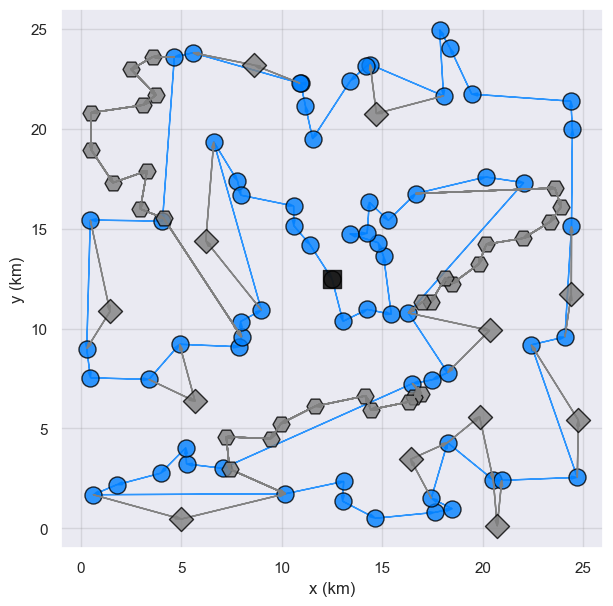

In [181]:
np.random.seed(0)
data = create_data_model(**controls)
VRPRD_routes = solve_routing_problem(data)

robot_routes = select_robot_nodes(data, VRPRD_routes)

for veh_i, group in enumerate(robot_routes):
    for index, route in enumerate(group):
        exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
        VRPRD_routes[veh_i] = [i for i in VRPRD_routes[veh_i] if i not in exclude_nodes]   
    VRPRD_routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, VRPRD_routes[veh_i], group)
    print(VRPRD_routes[veh_i], robot_routes[veh_i])

drone_routes = select_drone_nodes(data, VRPRD_routes, excludes=robot_routes)

for index, group in enumerate(drone_routes):
    for r in group:
        VRPRD_routes[index].remove(r[1])

drone_waiting = get_waiting_time(data, VRPRD_routes, drone_routes, 'drone')
robot_waiting = get_waiting_time(data, VRPRD_routes, robot_routes, 'robot')
print("Waiting time(d):", drone_waiting)
print("Waiting time(r):", robot_waiting)
total_dist, total_time, waiting_time = get_travelling_time(data, VRPRD_routes, drone_waiting, robot_waiting)

plot_map(routes=VRPRD_routes, drone_routes=drone_routes, robot_routes=robot_routes, **controls)

## Main: 設定參數與記錄實驗結果

In [182]:
def create_result_model():
    
    result = {}   
    # Parameters
    result["id"] = []
    result["map_size"] = []
    result["num_nodes"] = []
    result["num_locations"] = []
    result["num_vehicles"] = []
    result["vehicle_capacities"] = []
    # Result of VRP
    result["type"] = []
    result["truck_routes"] = []
    result["drone_routes"] = []
    result["robot_routes"] = []
    result["distances"] = []
    result["time"] = []
    result["waiting"] = []
    result["dispatch"] = []
    result["total_distance"] = []
    result["travel_time"] = []
    result["time_complexity"] = []
    result["space_complexity"] = []
    return result

def solve_by_VRP(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    total_dist, total_time, waiting_time = get_travelling_time(data, routes)
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRP_result = dict(type='VRP', truck_routes=routes,  drone_routes=np.nan, robot_routes=np.nan, distances=total_dist, time=total_time, waiting=np.nan, dispatch=np.nan, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRP_result

def solve_by_VRPD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    drone_routes = select_drone_nodes(data, routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = [[] for i in range(len(drone_waiting))]
    total_dist, total_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)
    # 考量派遣時間
    travel_time = total_time.copy()
    drone_dispatch = get_dispatch_time(drone_routes)
    for i, j in enumerate(drone_dispatch):
        travel_time[i] += waiting_time[i]
        travel_time[i] += j       
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPD_result = dict(type='VRP-D', truck_routes=routes, drone_routes=drone_routes, robot_routes=np.nan, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=drone_dispatch, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPD_result

def solve_by_VRPR(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for veh_i, group in enumerate(robot_routes):
        for index, route in enumerate(group):
            exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
            routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
        routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, routes[veh_i], group)
    robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')
    drone_waiting = [[] for i in range(len(robot_waiting))]
    total_dist, total_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)  
    # 考量派遣時間
    robot_dispatch = get_dispatch_time(robot_routes)
    for i, j in enumerate(robot_dispatch):
        total_time[i] += j        
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPR_result = dict(type='VRP-R', truck_routes=routes,  drone_routes=np.nan, robot_routes=robot_routes, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=robot_dispatch, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPR_result

def solve_by_VRPRD(data):
    start_time = time.time()
    tracemalloc.start()
    '''algorithm starts'''
    routes = solve_routing_problem(data)
    robot_routes = select_robot_nodes(data, routes)
    for veh_i, group in enumerate(robot_routes):
        for index, route in enumerate(group):
            exclude_nodes = [item for sublist in robot_routes[veh_i] for item in sublist if 0 < sublist.index(item) < len(sublist) - 1]
            routes[veh_i] = [i for i in routes[veh_i] if i not in exclude_nodes]   
        routes[veh_i], robot_routes[veh_i] = adjust_robot_route(data, routes[veh_i], group)
    drone_routes = select_drone_nodes(data, routes, excludes=robot_routes)
    for index, group in enumerate(drone_routes):
        for r in group:
            routes[index].remove(r[1])
    drone_waiting = get_waiting_time(data, routes, drone_routes, 'drone')
    robot_waiting = get_waiting_time(data, routes, robot_routes, 'robot')
    total_dist, total_time, waiting_time = get_travelling_time(data, routes, drone_waiting, robot_waiting)  
    # 考量派遣時間
    drone_dispatch = get_dispatch_time(drone_routes)
    robot_dispatch = get_dispatch_time(robot_routes)
    dispatch_time = [drone_dispatch[i]+robot_dispatch[i] for i in range(len(drone_dispatch))]
    for i, j in enumerate(zip(drone_dispatch, robot_dispatch)):
        total_time[i] += (j[0] + j[1])
    '''algorithm ends'''
    end_time = time.time()
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    time_complexity = round(end_time - start_time, 4)
    space_complexity = round(current / 1024, 4)
    VRPRD_result = dict(type='VRP-RD', truck_routes=routes, drone_routes=drone_routes, robot_routes=robot_routes, distances=total_dist, time=total_time, waiting=waiting_time, dispatch=dispatch_time, total_distance=np.sum(total_dist), travel_time=max(total_time), time_complexity=time_complexity, space_complexity=space_complexity)
    return VRPRD_result

def save_exp_parameter(iter, data, **controls):
    result["id"].append(iter)
    result["map_size"].append((controls["map_size"][0], controls["map_size"][1]))
    result["num_nodes"].append(data["num_nodes"])
    result["num_locations"].append(data["num_locations"])
    result["num_vehicles"].append(controls["num_vehicles"])
    result["vehicle_capacities"].append(data["vehicle_capacities"])

# 地圖大小, 客戶點數量, 車輛數, 模擬次數
def simulate_experiment(**controls):

    for iter in range(1, controls["trials"]+1):
        print(f'Trial {iter}...')
        data = create_data_model(**controls)
        # 解 VRP & 記錄結果
        try:
            print('VRP')
            VRP_result = solve_by_VRP(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRP_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP Error!')
        # 解 VRP-D & 記錄結果
        try:
            print('VRP-D')
            VRPD_result = solve_by_VRPD(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRPD_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP-D Error!')
        # 解 VRP-R & 記錄結果
        try:
            print('VRP-R')
            VRPR_result = solve_by_VRPR(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRPR_result.items():
                if key in result:
                    result[key].append(value)
        except: 
            print('VRP-R Error!')
        # 解 VRP-RD & 記錄結果
        try:
            print('VRP-RD')
            VRPRD_result = solve_by_VRPRD(data)
            save_exp_parameter(iter, data, **controls)
            for key, value in VRPRD_result.items():
                if key in result:
                    result[key].append(value)
        except:
            print('VRP-RD Error!')

    print('\nDone!')

## 執行實驗

In [201]:
# 記錄結果
result = create_result_model()

map_size = (5, 5)
num_node = 210
num_trial = 30

# 設定實驗參數 & 實驗
ex_controls = dict(map_size=map_size, num_nodes=num_node, num_vehicles=1, trials=num_trial)
simulate_experiment(**ex_controls)

Trial 1...
VRP
Routes: [[0, 22, 192, 10, 66, 161, 186, 136, 149, 141, 154, 106, 29, 79, 63, 68, 81, 109, 89, 32, 64, 127, 135, 99, 131, 60, 162, 65, 171, 150, 14, 59, 40, 132, 34, 191, 121, 111, 187, 71, 170, 20, 91, 95, 193, 144, 200, 45, 156, 172, 126, 46, 157, 18, 17, 202, 31, 147, 116, 208, 142, 75, 104, 182, 114, 86, 92, 96, 155, 9, 85, 15, 148, 38, 179, 160, 112, 201, 102, 13, 204, 105, 39, 88, 195, 133, 61, 7, 56, 167, 125, 28, 44, 177, 108, 118, 100, 137, 69, 120, 50, 37, 77, 180, 199, 145, 181, 1, 153, 84, 83, 78, 169, 52, 178, 152, 98, 72, 174, 49, 80, 196, 19, 58, 41, 134, 188, 123, 82, 205, 30, 119, 194, 12, 107, 158, 2, 138, 203, 93, 8, 165, 146, 113, 197, 168, 67, 11, 103, 35, 163, 62, 159, 129, 42, 57, 54, 101, 117, 74, 151, 128, 175, 55, 206, 16, 183, 130, 185, 198, 143, 4, 209, 189, 6, 207, 26, 76, 87, 110, 124, 33, 190, 164, 47, 122, 27, 140, 90, 24, 139, 51, 43, 176, 166, 48, 184, 21, 5, 36, 25, 97, 173, 115, 70, 3, 23, 53, 94, 73, 0]], Length: 211
Vehicle 0: 71461 m

In [202]:
df_result = pd.DataFrame(result)
df_result

,id,map_size,num_nodes,num_locations,num_vehicles,vehicle_capacities,type,truck_routes,drone_routes,robot_routes,distances,time,waiting,dispatch,total_distance,travel_time,time_complexity,space_complexity
0,1,"(5, 5)",210,"[(2.5, 2.5), (4.947, 3.071), (3.308, 2.931), (...",1,[210],VRP,"[[0, 22, 192, 10, 66, 161, 186, 136, 149, 141,...",NaN,NaN,[71461],[491.461],[0],0,71461,491.461,3.4456,4.9473
1,1,"(5, 5)",210,"[(2.5, 2.5), (4.947, 3.071), (3.308, 2.931), (...",1,[210],VRP-D,"[[0, 22, 192, 10, 66, 161, 186, 136, 149, 141,...","[[[83, 78, 169], [62, 159, 129], [132, 34, 191...",NaN,[66541],[468.401],[15.86],[34],66541,468.401,3.9492,9.0293
2,1,"(5, 5)",210,"[(2.5, 2.5), (4.947, 3.071), (3.308, 2.931), (...",1,[210],VRP-R,"[[0, 106, 29, 79, 63, 68, 81, 109, 89, 32, 64,...",NaN,"[[[93, 8, 165, 146, 113, 197, 168, 67, 11, 103...",[60636],[391.501],[54.865],[16],60636,391.501,3.3019,23.9941
3,1,"(5, 5)",210,"[(2.5, 2.5), (4.947, 3.071), (3.308, 2.931), (...",1,[210],VRP-RD,"[[0, 106, 29, 79, 63, 68, 81, 109, 89, 32, 64,...","[[[83, 78, 169], [62, 159, 129], [26, 76, 87],...","[[[93, 8, 165, 146, 113, 197, 168, 67, 11, 103...",[57243],[401.251],[68.008],[36],57243,401.251,4.0676,18.9150
4,2,"(5, 5)",210,"[(2.5, 2.5), (4.74, 1.698), (0.735, 4.262), (0...",1,[210],VRP,"[[0, 193, 95, 191, 53, 198, 167, 136, 88, 91, ...",NaN,NaN,[70735],[490.735],[0],0,70735,490.735,6.2699,4.4912
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,29,"(5, 5)",210,"[(2.5, 2.5), (3.157, 2.292), (2.945, 0.163), (...",1,[210],VRP-RD,"[[0, 204, 191, 33, 157, 132, 8, 172, 129, 89, ...","[[[175, 123, 141], [138, 93, 135], [148, 149, ...","[[[118, 170, 68, 102, 161, 144, 12, 177, 179, ...",[59110],[363.884],[10.774],[36],59110,363.884,4.3262,28.9287
116,30,"(5, 5)",210,"[(2.5, 2.5), (0.347, 3.618), (0.367, 0.495), (...",1,[210],VRP,"[[0, 171, 166, 200, 26, 78, 77, 9, 3, 137, 136...",NaN,NaN,[71259],[491.259],[0],0,71259,491.259,4.8988,4.3809
117,30,"(5, 5)",210,"[(2.5, 2.5), (0.347, 3.618), (0.367, 0.495), (...",1,[210],VRP-D,"[[0, 171, 166, 200, 26, 78, 77, 9, 3, 136, 130...","[[[152, 111, 157], [125, 196, 60], [172, 198, ...",NaN,[65713],[467.939],[16.226],[34],65713,467.939,4.4685,6.1289
118,30,"(5, 5)",210,"[(2.5, 2.5), (0.347, 3.618), (0.367, 0.495), (...",1,[210],VRP-R,"[[0, 171, 166, 200, 26, 78, 77, 9, 3, 137, 136...",NaN,"[[[48, 46, 54, 103, 31, 149, 88, 182, 162, 179...",[63132],[367.857],[10.725],[14],63132,367.857,4.3743,23.4141


<AxesSubplot: xlabel='id', ylabel='travel_time'>

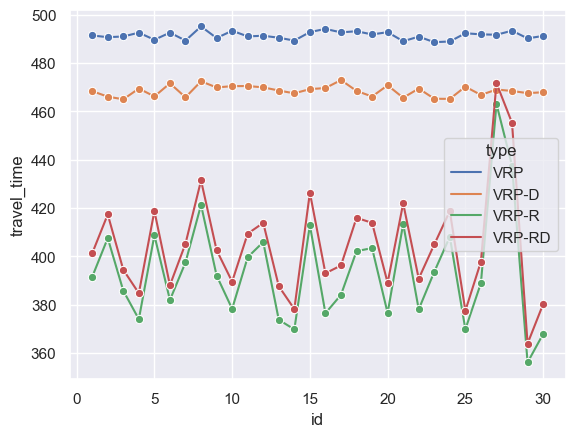

In [203]:
sns.lineplot(data=df_result, x='id', y='travel_time', hue='type', marker='o')

In [204]:
from datetime import datetime
from datetime import date

In [205]:
today = date.today()
now = datetime.now()
today_str = today.strftime("%Y-%m-%d")
current_time = now.strftime("%H-%M-%S-%f")
current_time
df_result.to_csv(f'./result/vrp_result_{map_size[0]}x{map_size[1]}_{num_trial}_{today_str}_{current_time}.csv', index=False)